# Analyse du trafic cycliste à Paris en fonction de la météo

Ce mini-projet d'extraction et d'analyse de données autour du trafic cycliste à Paris a pour objectif :
- Comprendre et appliquer le concept d'ETL (Extract, Trasnform, Load)
- Explorer des données ouvertes (open data)
- Croiser deux sources de données (API + scraping)
- Stocker les données dans une base SQL (SQLite3)
- Réaliser une visualisation (Streamlit) et/ou un modèle simple

Précisions quant au concept d'ETL :
- **Extract**: récupérer des données depuis une source (API, fichier, web...)
- **Transform**: nettoyer, reformater, enrichir les données
- **Load**: stocker les données dans une format structuré (CSV, DB, ...)

On souhaite répondre à la problématique suivante :

**Comment la météo influence-t-elle l'utilisation des pistes cyclables à Paris ?**

---

## Libraries

In [25]:
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import  datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from meteocielprocessor import MeteocielProcessor

## Extraction des données
Sources :

- [Données météo station Tour Eiffel](https://www.meteociel.fr/climatologie/obs_villes.php)
- [Données compteurs de vélos pour le site de comptage nommé 36 quai de Grenelle](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/api/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name)


### Scraping Meteociel

In [8]:
meteociel_processor = MeteocielProcessor()
start_date = datetime.date(year=2024, month=1, day=1)
end_date = datetime.date(year=2025, month=12, day=1)

df_meteociel = meteociel_processor.get_daily_data_from_period(start_date.month, start_date.year, end_date.month, end_date.year)
df_meteociel.head()

,temp_max,temp_min
date,,
2024-01-01,9.6,4.9
2024-01-02,10.7,7.4
2024-01-03,10.3,8.4
2024-01-04,9.6,6.2
2024-01-05,6.8,4.4


### API Open Data

In [9]:
def update_cyclist_data(data, offset):
    url = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/comptage-velo-donnees-compteurs/records"
    params = {
        "select": ["sum_counts","date"],
        "limit": 100,
        "offset": offset,
        "refine": ['nom_compteur:36 quai de Grenelle NE-SO']
        }
    response = json.loads(
        requests.get(url, params).content
        )
    
    data["date"] = data["date"] + [dic['date'] for dic in response["results"]]
    data["sum_count"] = data["sum_count"] + [dic['sum_counts'] for dic in response["results"]]

def get_total_count():
    url = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/comptage-velo-donnees-compteurs/records"
    offset = 0
    params = {
        "select": ["sum_counts","date"],
        "limit": 0,
        "offset": offset,
        "refine": ['nom_compteur:36 quai de Grenelle NE-SO']
        }
    response = json.loads(
        requests.get(url, params).content
        )
    return response['total_count']

In [10]:
data = {
    "date": [],
    "sum_count": []
    }
offset = 0
while offset <= get_total_count():
    update_cyclist_data(data, offset)
    offset += 100

In [26]:
df_cyclist = pd.DataFrame(data)
df_cyclist["date"] = pd.to_datetime(df_cyclist["date"])
df_cyclist = df_cyclist.set_index("date")

## Transformation des données

Les données de comptage de vélo sont échantillonnées toutes les heures, là où les données de températures sont quotidiennes.
- Nous commençons donc par récupérer le compte journalier de vélo avec un `groupby().sum()`
- Avant de pouvoir `join` les deux tables.

In [28]:
df_cyclist = df_cyclist.groupby(df_cyclist.index.date).sum()
df_cyclist.head()

,sum_count
2024-11-01,1389
2024-11-02,1601
2024-11-03,1409
2024-11-04,2947
2024-11-05,3125


In [13]:
df = df_cyclist.join(df_meteociel, how='left')
df.head()

,sum_count,temp_max,temp_min
2024-11-01,1389,10.3,7.1
2024-11-02,1601,9.8,7.6
2024-11-03,1409,8.5,7.1
2024-11-04,2947,12.7,6.6
2024-11-05,3125,11.7,6.4


## Stockage des données 
D'abord en `CSV`.

In [14]:
# En CSV
df_meteociel.to_csv("../data/daily-temperatures-2024-2025.csv")
df_cyclist.to_csv("../data/cyclists-2024-2025.csv")
df.to_csv("../data/cyclist-temp-2024-2025.csv")

Puis dans une base de données `SQLite`

In [22]:
engine = create_engine('sqlite:///../db/cyclist-temp.db', echo=True)
sqlite_connection = engine.connect()

In [23]:
df.to_sql(name="cyclist-temp", con=sqlite_connection)

2025-12-23 12:01:10,979 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-12-23 12:01:10,982 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("cyclist-temp")
2025-12-23 12:01:10,982 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-12-23 12:01:10,984 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("cyclist-temp")
2025-12-23 12:01:10,985 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-12-23 12:01:10,987 INFO sqlalchemy.engine.Engine 
CREATE TABLE "cyclist-temp" (
	"index" DATETIME, 
	sum_count BIGINT, 
	temp_max FLOAT, 
	temp_min FLOAT
)


2025-12-23 12:01:10,988 INFO sqlalchemy.engine.Engine [no key 0.00066s] ()
2025-12-23 12:01:10,991 INFO sqlalchemy.engine.Engine CREATE INDEX "ix_cyclist-temp_index" ON "cyclist-temp" ("index")
2025-12-23 12:01:10,992 INFO sqlalchemy.engine.Engine [no key 0.00059s] ()
2025-12-23 12:01:11,003 INFO sqlalchemy.engine.Engine INSERT INTO "cyclist-temp" ("index", sum_count, temp_max, temp_min) VALUES (?, ?, ?, ?)
2025-12-23 12:01:11,004 INFO sqlalc

417

In [24]:
sqlite_connection.close()

## Visualisation des données

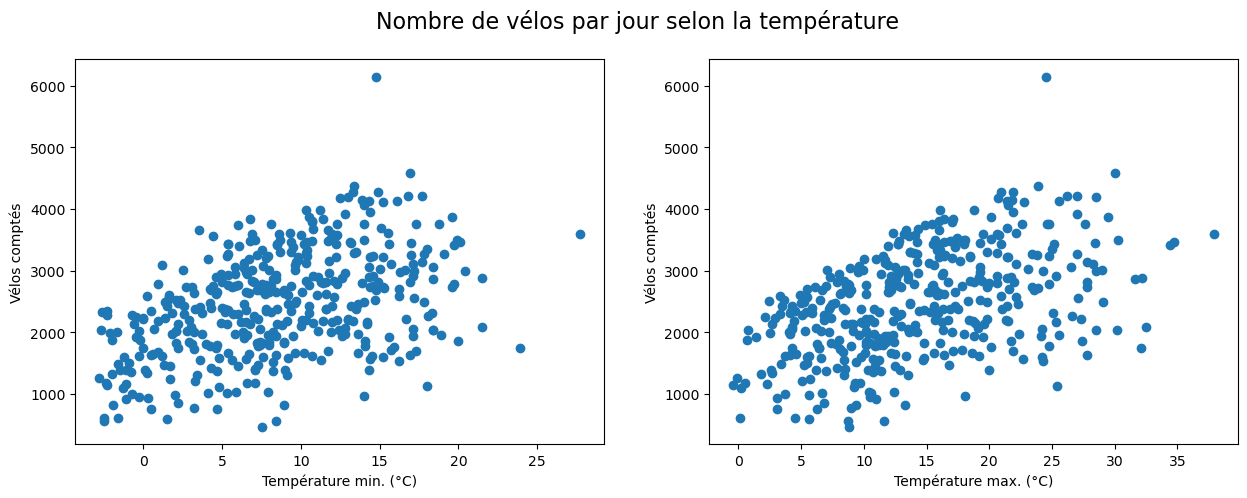

In [56]:
fig, axes = plt.subplots(1,2,figsize=(15, 5))
axes[0].scatter(df["temp_min"], df["sum_count"])
axes[0].set_xlabel("Température min. (°C)")
axes[0].set_ylabel("Vélos comptés")
axes[1].scatter(df["temp_max"], df["sum_count"])
axes[1].set_xlabel("Température max. (°C)")
axes[1].set_ylabel("Vélos comptés")
fig.suptitle("Nombre de vélos par jour selon la température", fontsize=16)
plt.show()